# Curso IML1 - Unidade 1 - Regressão

Análise do conjunto de dados da [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)

Livro: **Aprendizado de máquina: uma abordagem estatística** (http://www.rizbicki.ufscar.br/ame/)

# Upload do conjunto de dados

O conjunto de dados utilizados para demonstração dos métodos é uma amostra do [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews).

Para abrir o arquivo, precisamos fazer o upload para o Driver.

In [1]:
# o código abaixa conecta o ambiente em execução com o Google Driver
#from google.colab import drive
#drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Selecione **Arquivos** no meu lateral esquerdo e clique em **Fazer upload para armazenamento da sessão**.

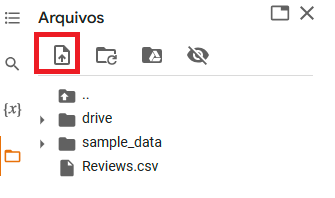

Selecione o arquivo **Reviews.csv** na sua máquina.

# Bibliotecas

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import numpy as npbest_estimator_
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import re

# modelos
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers

# selecao modelos
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
# interpretacao
from sklearn.inspection import PartialDependenceDisplay
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')

nltk.download('punkt_tab')
nltk.download('omw-1.4')
#from sklearn.inspection import plot_partial_dependence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Ler e processar dados

Os dados abrangem um período de mais de 10 anos, incluindo todas as aproximadamente 500.000 análises até outubro de 2012. As análises incluem informações sobre produtos e usuários, classificações e uma análise em texto simples. Também inclui avaliações de todas as outras categorias da Amazon.

In [ ]:
# abrindo arquivo
data = pd.read_csv("./Reviews.csv", nrows=10_000)
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


None

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Nosso objetivo é estimar o score de um review com base no comentário feito. Portanto, vamos utilizar a coluna **Text** para criar as covariáveis e a coluna **Score** será nosso label.

<Axes: ylabel='Score'>

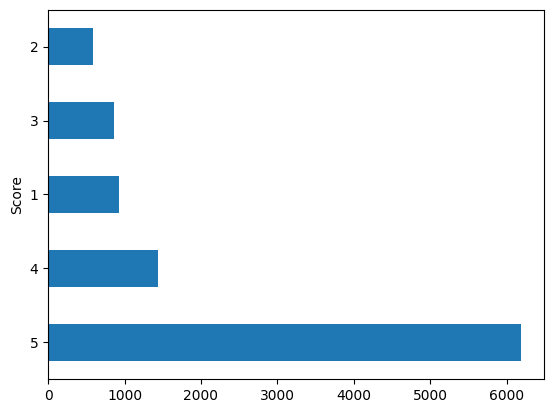

In [ ]:
y = data['Score'].copy()
X = data['Text'].copy()

# frequencia da variavel dependente
y.value_counts().plot(kind = 'barh')

## Tratando os dados

Nosso conjunto de treino são os textos dos reviews feitos. Para conseguir utilizar o modelos de ML, precisamos transformar nosso dados em uma matriz de números. Utilizaremos a técnica Bag of Words para criar uma matriz de contagens de palavras.

Etapas que serão aplicadas:
*   Removendo números
*   Removendo pontuações
*   Passando o texto para minúsculo
*   Dividindo em treino e teste
*   Transformando em matriz de contagens (Bag of Words)

In [ ]:
X.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [ ]:
# Removendo numeros e passando para minusculo
X = (
    X
    .str.replace(r'[^\w\s]|[\d]', '', regex = True)
    .str.lower()
    )

X.head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price  there was a wide...
Name: Text, dtype: object

In [2]:
# dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/10, random_state = 0)

NameError: name 'X' is not defined

In [ ]:
# transformando em matriz de contagens
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

# a palavras serão criadas a partir dos dados de treino
cv = CountVectorizer(
    tokenizer=LemmaTokenizer(), max_features=1_500, stop_words='english',
    token_pattern=r'(?u)\b\w\w\w+\b', min_df=0.005, binary=True)
X_train = cv.fit_transform(X_train)
# aplicando nos dados de teste
X_test = cv.transform(X_test)
# palabras utilizadas
features = cv.get_feature_names_out()


print(f"Dimensão do conjunto de treino: {X_train.shape}")
X_train.toarray()

Dimensão do conjunto de treino: (9000, 973)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Regressão

Utilizaremos o conjunto de treino para ajustar os modelos e escolheremos o modelo com menor MSE no conjunto de teste.

In [ ]:
# dataframe que armazenará o resultado dos modelos
resultados = pd.DataFrame(columns = ['Method', 'MSE'])

In [ ]:
def plot_coefs(features, coefs, n=20, split_by_sign=True):
    df = pd.DataFrame({'feature': features, 'coef': coefs})

    # Filtrando e ordenando os dados
    coefs_negativos = df.nsmallest(n, 'coef').loc[lambda df: df.coef < 0].sort_values('coef', ascending=False)
    coefs_positivos = df.nlargest(n, 'coef').loc[lambda df: df.coef >= 0].sort_values('coef', ascending=True)
    trace_positivo = go.Bar(
        y=coefs_positivos['feature'], x=coefs_positivos['coef'],
        orientation='h', marker=dict(color='blue'))
    # Criando o subplot
    if split_by_sign:
        fig = make_subplots(rows=1, cols=2, subplot_titles=('Coeficientes Negativos', 'Coeficientes Positivos'))
        fig.add_trace(
            go.Bar(
                y=coefs_negativos['feature'], x=coefs_negativos['coef'],
                orientation='h', marker=dict(color='red'),
                name='Coeficientes Negativos'),
            row=1, col=1)
        fig.add_trace(trace_positivo, row=1, col=2)
        width = 1200
    else:
        fig = make_subplots(rows=1, cols=1, subplot_titles=('Coeficientes',))
        fig.add_trace(trace_positivo, row=1, col=1)
        width = 600
    fig.update_layout(barmode='stack', showlegend=False, width=width, height=800)
    fig.show()

In [ ]:
# função que plota a Nota real vs Nota Predita
def plot_predict(y_test, y_predict):
  fig = px.strip(pd.DataFrame({'Nota real': y_test, 'Nota predita': y_predict}), x='Nota real', y='Nota predita', width=600)
  fig.show()

## MMQ

In [ ]:
#linear = linear_model.LinearRegression().fit(X_train, y_train)

In [ ]:
# treinando modelo
linear = linear_model.LinearRegression().fit(X_train, y_train)

# plotando maiores coeficientes
plot_coefs(features=features, coefs=linear.coef_)

# plotando nota real x nota predita
plot_predict(y_test, y_predict = linear.predict(X_test))

resultados.loc[len(resultados)] = {
    'Method': "Mínimos Quadrados",
    'MSE': mse(linear.predict(X_test), y_test)}

print('RESULTADOS: ')
display(resultados)

RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752


### Seleção de variáveis

O método do MMQ é sensível a presença de muitas covariáveis correlacionadas entre si e com pouca informação sobre a variável alvo.
Aplicaremos o método [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que elimina de recursos recursivamente com validação cruzada. Em resumo, o modelo é ajustado e as variáveis com menor importância são descartadadas. Esse prodicedimento é aplicador até obter um número mínimo de variáveis.

In [ ]:
from sklearn.feature_selection import RFECV
linear = linear_model.LinearRegression()
linear_rfe = RFECV(
    linear, min_features_to_select=200,
    step=0.3, verbose=10, cv=2
    ).fit(X_train,y_train)
print('Variáveis selecionadas: ', features[linear_rfe.support_])

Fitting estimator with 973 features.
Fitting estimator with 682 features.
Fitting estimator with 391 features.
Fitting estimator with 973 features.
Fitting estimator with 682 features.
Fitting estimator with 391 features.
Fitting estimator with 973 features.
Fitting estimator with 682 features.
Fitting estimator with 391 features.
Variáveis selecionadas:  ['allergic' 'amazing' 'area' 'asked' 'avoid' 'away' 'awesome' 'awful'
 'bad' 'bar' 'barely' 'best' 'bland' 'brewed' 'brought' 'bulk' 'bunch'
 'caramel' 'care' 'check' 'chewy' 'claim' 'coat' 'comment' 'company'
 'consistency' 'convenient' 'cool' 'creamer' 'crisp' 'date' 'delicious'
 'description' 'did' 'dip' 'disappointed' 'disappointing' 'donut' 'door'
 'drop' 'earth' 'ended' 'enjoying' 'exactly' 'excellent' 'fast' 'feeding'
 'felt' 'fiber' 'flat' 'followed' 'form' 'forward' 'gave' 'giving' 'glad'
 'great' 'ground' 'grove' 'happy' 'heard' 'helped' 'highly' 'honestly'
 'hooked' 'hoping' 'horrible' 'iced' 'idea' 'impressed' 'individual'

In [ ]:
# treinando modelo
linear = linear_model.LinearRegression().fit(X_train[:,linear_rfe.support_],y_train)

# plotando maiores coeficientes
plot_coefs(
    features=[i for (i, v) in zip(features, linear_rfe.support_) if v],
    coefs=linear.coef_)

# plotando nota real x nota predita
plot_predict(y_test, y_predict=linear.predict(X_test[:,linear_rfe.support_]))

# salvando resultados
resultados.loc[len(resultados)] = {
    'Method': "Mínimos Quadrados RFE",
    'MSE': mse(linear.predict(X_test[:,linear_rfe.support_]), y_test)}
print('RESULTADOS: ')
display(resultados)

RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076


## Lasso

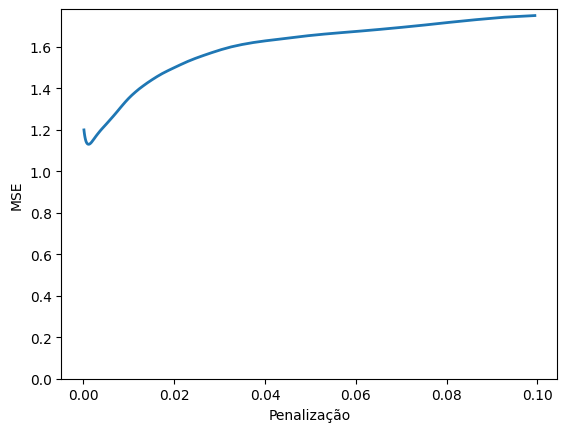

Best Alpha: 0.0011434662632345209
Número de coeficientes iguais a 0: 463


RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076
2,Lasso,1.126104


In [ ]:
# treinando modelo
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)

# plotando MSE x Penalização
plt.figure()
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1),linewidth=2)
plt.ylim(bottom=0)
plt.xlabel('Penalização')
plt.ylabel('MSE')
plt.show()

# imprimir melhor alpha
print(f'Best Alpha: {lasso.alpha_}')
print(f'Número de coeficientes iguais a 0: {sum(lasso.coef_ == 0)}')

# plotando maiores coeficientes
plot_coefs(features=features, coefs=lasso.coef_)

# plotando nota real x nota predita
plot_predict(y_test, y_predict=lasso.predict(X_test))

resultados.loc[len(resultados)] = {
    'Method': "Lasso",'MSE': mse(lasso.predict(X_test), y_test)}
print('RESULTADOS: ')
display(resultados)

## KNN

Best Paramns: {'n_neighbors': 21}


RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076
2,Lasso,1.126104
3,KNN,1.563669


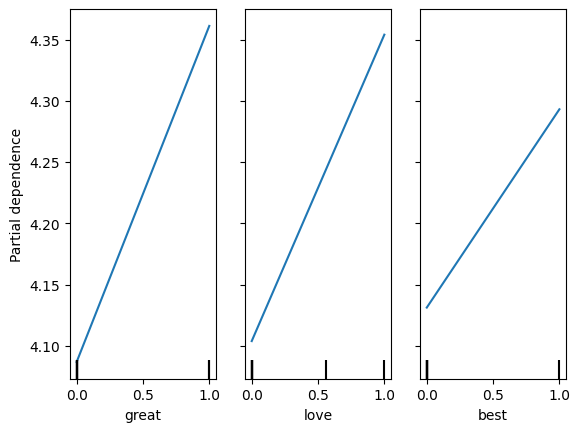

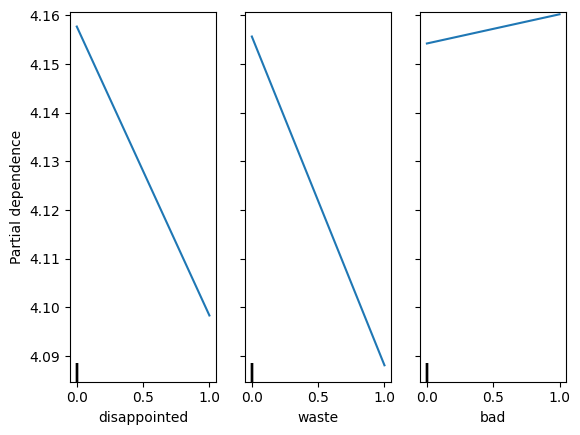

In [ ]:
# criando modelo
knn = KNeighborsRegressor()

# otimização de hiperparametros
param_grid = {'n_neighbors': np.arange(1, 100, 5)}
knn_gscv = GridSearchCV(knn, param_grid, cv=5,
                        scoring = make_scorer(mse,greater_is_better=False))
knn_gscv.fit(pd.DataFrame(X_train.toarray(), columns=features), y_train)

print(f'Best Paramns: {knn_gscv.best_params_}')

px.line(x=param_grid['n_neighbors'], y=knn_gscv.cv_results_['mean_test_score']*-1, width=600).show()

# plotando partial dependence
PartialDependenceDisplay.from_estimator(knn_gscv, pd.DataFrame(X_test.todense(), columns=features), ['great','love', 'best'])
PartialDependenceDisplay.from_estimator(knn_gscv, pd.DataFrame(X_test.todense(), columns=features), ['disappointed' , 'waste',  'bad'])

# plotando nota real x nota predita
plot_predict(y_test, y_predict=knn_gscv.predict(pd.DataFrame(X_test.toarray(), columns=features)))

# salvando resultados
resultados.loc[len(resultados)] = {
    'Method': "KNN",'MSE': mse(knn_gscv.predict(pd.DataFrame(X_test.toarray(), columns=features)), y_test)}
print('RESULTADOS: ')
display(resultados)

In [ ]:
# criando modelo
knn = KNeighborsRegressor()

# otimização de hiperparametros
param_grid = {'n_neighbors': np.arange(1, 100, 5)}
knn_gscv = GridSearchCV(knn, param_grid, cv=5,
                        scoring = make_scorer(mse,greater_is_better=False))
knn_gscv.fit(pd.DataFrame(X_train[:, linear_rfe.support_].todense(), columns=features[linear_rfe.support_]), y_train)

print(f'Best Paramns: {knn_gscv.best_params_}')

px.line(x=param_grid['n_neighbors'], y=knn_gscv.cv_results_['mean_test_score']*-1, width=600).show()

# plotando nota real x nota predita
y_predict = knn_gscv.predict(pd.DataFrame(X_test[:, linear_rfe.support_].todense(), columns=features[linear_rfe.support_]))
plot_predict(y_test, y_predict=y_predict)

# salvando resultados
resultados.loc[len(resultados)] = {
    'Method': "KNN RFE",'MSE': mse(y_predict, y_test)}

print('RESULTADOS: ')
display(resultados)

Best Paramns: {'n_neighbors': 11}


RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076
2,Lasso,1.126104
3,KNN,1.563669
4,KNN RFE,1.440843


## Árvore

{'max_depth': 8}


RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076
2,Lasso,1.126104
3,KNN,1.563669
4,KNN RFE,1.440843
5,Árvore de Decisão,1.602377


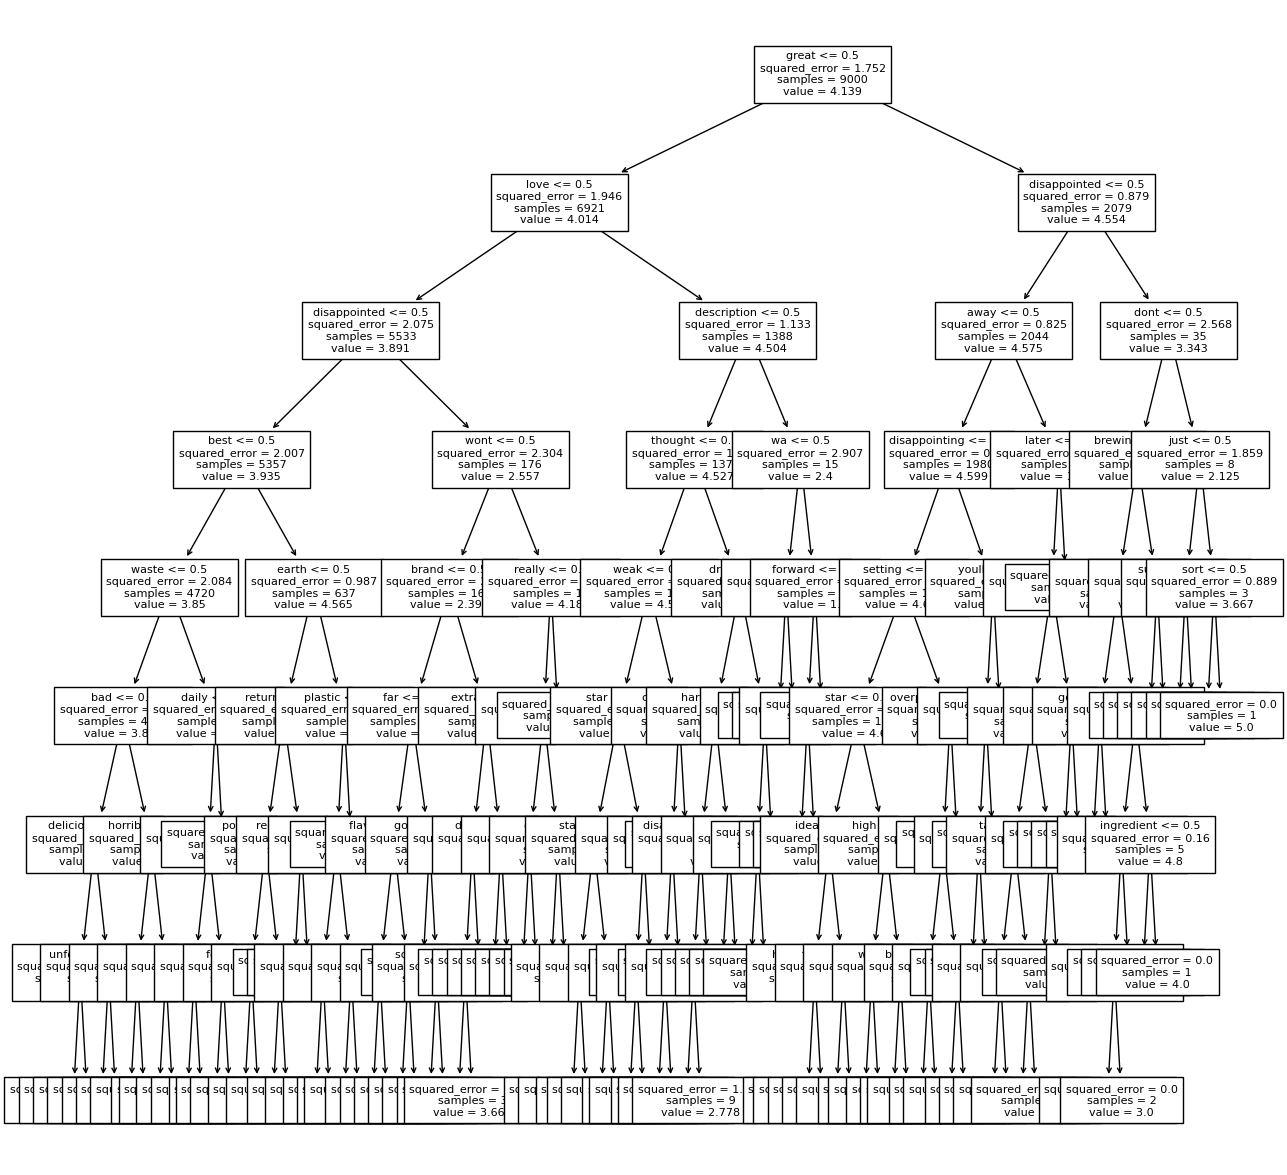

In [ ]:
# criando modelo
tree = DecisionTreeRegressor(random_state=0)

# otimização de hiperparametros
param_grid = {'max_depth':np.arange(1, 20)}
tree_gscv = GridSearchCV(tree, param_grid, cv=5,scoring=make_scorer(mse,greater_is_better=False))
tree_gscv.fit(X_train, y_train)
print(tree_gscv.best_params_)

px.line(x=param_grid['max_depth'], y=tree_gscv.cv_results_['mean_test_score']*-1, width=600).show()

plot_coefs(features=features, coefs=tree_gscv.best_estimator_.feature_importances_, split_by_sign=False)

fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(tree_gscv.best_estimator_, fontsize=8, ax=ax, feature_names=features)
fig.show()

# salvando resultados
resultados.loc[len(resultados)] = {
    'Method': "Árvore de Decisão",'MSE': mse(tree_gscv.predict(X_test), y_test)}

print('RESULTADOS: ')
display(resultados)

## Floresta

In [ ]:
# criando modelo
floresta = RandomForestRegressor(random_state = 0)

# otimização de hiperparametros
param_grid = {'max_depth': [3, 7, 15], 'n_estimators': [100, 200, 300], 'max_samples': [.8, None], 'min_samples_split': [2, 5, 10]}
floresta_rscv = RandomizedSearchCV(floresta, param_grid, cv=5, scoring=make_scorer(mse,greater_is_better=False), n_iter=10)
floresta_rscv.fit(X_train, y_train)
print(floresta_rscv.best_params_)

KeyboardInterrupt: 

RESULTADOS: 


,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076
2,Lasso,1.126104
3,KNN,1.563669
4,KNN RFE,1.440843
5,Árvore de Decisão,1.602377
6,Floresta,1.274628


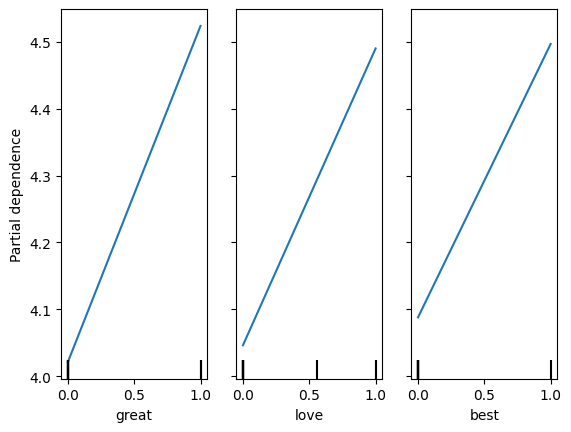

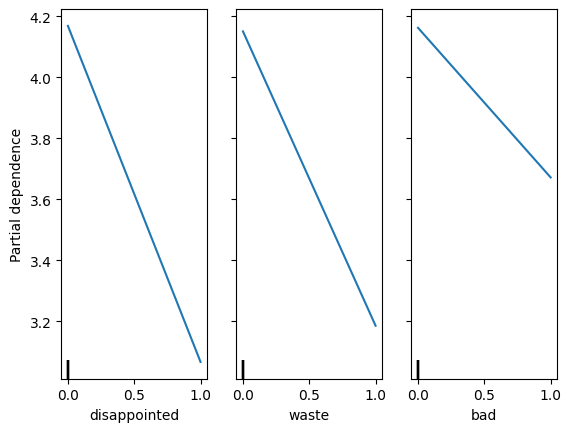

In [ ]:
# utilizando o melhores parametros
floresta.set_params(**floresta_rscv.best_params_)
floresta.fit(X_train,y_train)

plot_coefs(features=features, coefs=floresta.feature_importances_, split_by_sign=False)

# plotando partial dependence
PartialDependenceDisplay.from_estimator(floresta, pd.DataFrame(X_test.todense(), columns=features), ['great','love', 'best'])
PartialDependenceDisplay.from_estimator(floresta, pd.DataFrame(X_test.todense(), columns=features), ['disappointed' , 'waste',  'bad'])

# salvando resultados
resultados.loc[len(resultados)] = {
    'Method': "Floresta",'MSE': mse(floresta.predict(X_test), y_test)}

print('RESULTADOS: ')
display(resultados)

## XGBoost

In [ ]:
# criando modelo
xgb_model = xgb.XGBRegressor(early_stopping_rounds=10)

# otimização de hiperparametros
parameters = {'max_depth': [3,7,12],
              'min_child_weight': [5,10,20],
              'subsample': [0.8,1],
              'colsample_bytree': [0.75,1],
              'n_estimators': [400],
              'eta':[0.01,0.1,0.5]}

X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=7)
eval_set = [(X_train_1,y_train_1),(X_val, y_val)]

xgb_model_gscv = RandomizedSearchCV(xgb_model, parameters, n_jobs=4, cv=2,scoring=make_scorer(mse,greater_is_better=False), n_iter=10)
xgb_model_gscv.fit(
    X_train_1, y_train_1,
    eval_set=eval_set,
    verbose=0)


print(xgb_model_gscv.best_params_)
xgb_results = xgb_model_gscv.best_estimator_.evals_result()

# plot
epochs = len(xgb_results['validation_0']['rmse'])
x_axis = range(0, epochs)
px.line(pd.concat([
    pd.DataFrame({'epoch': x_axis, 'RMSE': xgb_results['validation_0']['rmse']}).assign(dataset='Train'),
    pd.DataFrame({'epoch': x_axis, 'RMSE': xgb_results['validation_1']['rmse']}).assign(dataset='Validation'),
]), x='epoch', y='RMSE', color='dataset', width=650).show()

# plotando as variaveis mais importantes
plot_coefs(features=features, coefs=xgb_model_gscv.best_estimator_.feature_importances_, split_by_sign=False)

# salvando resultados
resultados.loc[len(resultados)] = {
    'Method': "XGBoost",'MSE': mse(xgb_model_gscv.predict(X_test), y_test)}

print(resultados)

{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0.75}


                  Method       MSE
0      Mínimos Quadrados  1.215752
1  Mínimos Quadrados RFE  1.222076
2                  Lasso  1.126104
3                    KNN  1.563669
4                KNN RFE  1.440843
5      Árvore de Decisão  1.602377
6               Floresta  1.274628
7                XGBoost  1.053299


## NNets

In [ ]:
X_train.shape[1]

973

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │        29,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,951 (117.00 KB)

 Trainable params: 29,951 (117.00 KB)

 Non-trainable params: 0 (0.00 B)

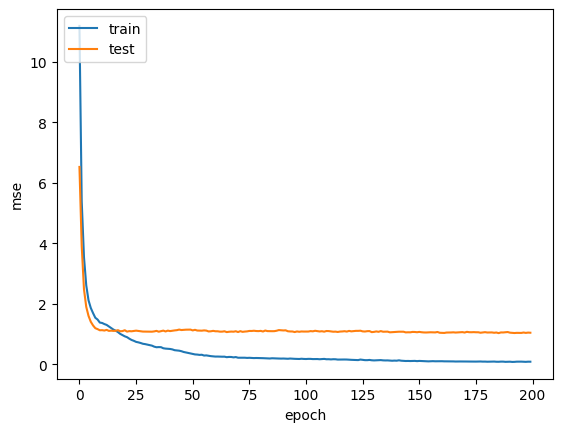

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                  Method       MSE
0      Mínimos Quadrados  1.215752
1  Mínimos Quadrados RFE  1.222076
2                  Lasso  1.126104
3                    KNN  1.563669
4                KNN RFE  1.440843
5      Árvore de Decisão  1.602377
6               Floresta  1.274628
7                XGBoost  1.053299
8                  NNets  1.195156


In [ ]:
N

## Resultados

In [ ]:
resultados

,Method,MSE
0,Mínimos Quadrados,1.215752
1,Mínimos Quadrados RFE,1.222076
2,Lasso,1.126104
3,KNN,1.563669
4,KNN RFE,1.440843
5,Árvore de Decisão,1.602377
6,Floresta,1.274628
7,XGBoost,1.053299
8,NNets,1.195156
